In [1]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
from skimage import transform, color
import cv2 as cv

tuple2int = {
    (1, 1, 1, 1, 1, 1, 0) : 0,
    (0, 1, 1, 0, 0, 0, 0) : 1,
    (1, 1, 0, 1, 1, 0, 1) : 2,
    (1, 1, 1, 1, 0, 0, 1) : 3,
    (0, 1, 1, 0, 0, 1, 1) : 4,
    (1, 0, 1, 1, 0, 1, 1) : 5,
    (0, 0, 1, 1, 1, 1, 1) : 6,
    (1, 1, 1, 0, 0, 0, 0) : 7,
    (1, 1, 1, 1, 1, 1, 1) : 8,
    (1, 1, 1, 0, 0, 1, 1) : 9
}

In [20]:
# импортируем видео и берём первый кадр
cap = cv.VideoCapture('video6v.mp4')
_, frame = cap.read()
cap.release()

# преобразуем в чб и обрезаем
img = color.rgb2gray(frame)[40:160, 60:840]

0.017812652011477813
0.07252897391369635
0.07612851128888085
0.011668756899630477
0.009897907649643245
0.010396053327018567
0.020293774688222698
[False, True, True, False, False, False, False]
1
0.011081219101728717
0.010300474182598952
0.07420413723973342
0.12003011758631126
0.07538455615095921
0.07012651622939371
0.14768129586493906
[False, False, True, True, True, True, True]
6
0.13483391597622127
0.07187739763540277
0.07657381551889356
0.030919602858241343
0.024470428268028456
0.0677808028655107
0.13869647966244802
[True, True, True, False, False, True, True]
9
0.09055033966418839
0.07099089673220446
0.09382713516126452
0.04741589011980885
0.04989093065807115
0.021457401545882965
0.03655624634585533
[True, True, True, False, False, False, False]
7
0.018706214079950084
0.07219967352758572
0.07511405639845604
0.011668756899630477
0.009897907649643245
0.01008685490193572
0.020172324508439414
[False, True, True, False, False, False, False]
1
0.011081219101728717
0.010300474182598952
0.

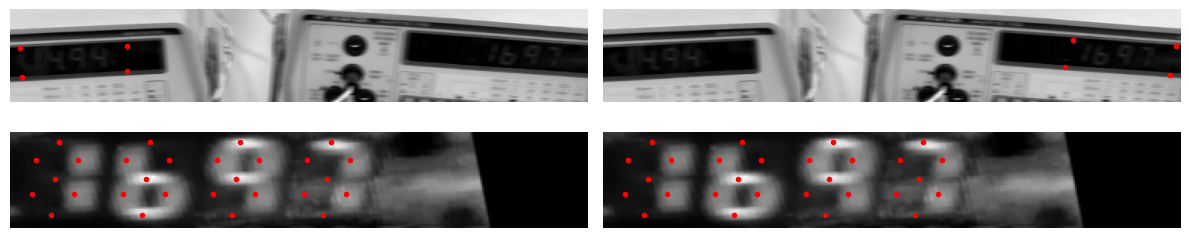

In [46]:
src = np.array([[0, 0], [0, 55], [230, 55], [230, 0]])
dst = [None, None]
dst[0] = np.array([[12, 50], [15, 88], [151, 80], [151, 48]])
dst[1] = np.array([[610, 40], [600, 75], [737, 85], [744, 48]])

warped = [None, None]
# warped = buf
tform3_1 = transform.ProjectiveTransform()
tform3_1.estimate(src, dst[0])
warped[0] = transform.warp(img, tform3_1, output_shape=(50, 300))

tform3_2 = transform.ProjectiveTransform()
tform3_2.estimate(src, dst[1])
warped[1] = transform.warp(img, tform3_2, output_shape=(50, 300))
warped[0] = buf

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 3))


segments = np.array([[9,34], [18, 44], [36, 42], [47,30], [36, 20], [18, 22], [28, 32]], dtype=int)

shift_x = [0, 0]
shift_y = [47, 47]
start_x = [-4, -4]
start_y = [-9, -9]

min_val = 0.055
delta = 1
for i in range(2):
    ax[0][i].imshow(img, cmap=plt.cm.gray)
    ax[0][i].plot(dst[i][:, 0], dst[i][:, 1], '.r')
    ax[1][i].imshow(warped[i], cmap=plt.cm.gray)

    sh_x = shift_x[i]
    sh_y = shift_y[i]
    numbers = np.array([[0, 0], [sh_x, sh_y], [2*sh_x, 2*sh_y], [3*sh_x, 3*sh_y]])
    for number in numbers:
        bool_arr = []
        for segment in (segments + number + (start_x[i], start_y[i])):
            ax[1][i].plot(segment[1], segment[0], '.r')
            area = warped[i][(segment[0] - delta):(segment[0] + delta), (segment[1] - delta):(segment[1] + delta)]

            bool_arr.append(np.mean(area) > min_val)
            print(np.mean(area))
        print(bool_arr)
        print(tuple2int[tuple(bool_arr)])
        
    for a in ax:
        a[i].axis('off')

plt.tight_layout()
plt.show()

In [47]:
buf = None

with open("data6v.csv", "w") as f:
    f.write("U[V], I[uA]\n")

cap = cv.VideoCapture('video6v.mp4')
prev = (0, 0)

while cap.isOpened():
    ret, frame = cap.read()
    
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    img = color.rgb2gray(frame)[40:160, 60:810]
    
    warped[0] = transform.warp(img, tform3_1, output_shape=(50, 300))
    warped[1] = transform.warp(img, tform3_2, output_shape=(50, 300))

    cv.imshow('frame', warped[1])
    
    if cv.waitKey(1) == ord('q'):
        break
    
    v_nums = [[], []]
    
    for i in range(2):
        sh_x = shift_x[i]
        sh_y = shift_y[i]
        numbers = np.array([[0, 0], [sh_x, sh_y], [2*sh_x, 2*sh_y], [3*sh_x, 3*sh_y]])
        for number in numbers:
            bool_arr = []
            for segment in (segments + number + (start_x[i], start_y[i])):
                area = warped[i][(segment[0] - delta):(segment[0] + delta), (segment[1] - delta):(segment[1] + delta)]
                bool_arr.append(np.mean(area) > min_val)

            try:
                v_nums[i].append(tuple2int[tuple(bool_arr)])
            except KeyError:
                buf = warped[i]
                print(f"Error: {i}")
                break
        
    if len(v_nums[0]) + len(v_nums[1]) == 8:
        U = float("".join(list(map(str, v_nums[0]))))/100
        I = float("".join(list(map(str, v_nums[1]))))/10
        if prev != (U, I):
            prev = (U, I)
            with open("data6v.csv", "a") as f:
                f.write(f"{U}, {I}\n")
        
cap.release()
cv.destroyAllWindows()

Error: 1
Error: 0
Error: 1
Error: 0
Error: 1
Error: 0
Error: 0
Error: 0
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 1
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
Error: 0
E